In [1]:
#!pip install shap


In [59]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import shap
import pickle

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
rerun = False # True

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/markusloecher/shap/master/Explore/titanicnoMissingAge.csv') # Load the data
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",2,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",2,35.0,0,0,373450,8.0500,NaN,S
5,7,0,1,"McCarthy, Mr. Timothy J",2,54.0,0,0,17463,51.8625,E46,S
6,8,0,3,"Palsson, Master. Gosta Leonard",2,2.0,3,1,349909,21.0750,NaN,S
7,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S
8,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C
9,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S


In [30]:
Y = df['Survived']
X =  df[['Age', 'Pclass','Sex', 'PassengerId']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [31]:
def plotImp(importances,features, main = 'Feature Importances',xlab='Relative Importance'):
    indices = np.argsort(importances)
    #features = X_train.columns
    plt.title(main)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel(xlab)
    plt.show()

In [32]:
rf = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=100,max_features=2)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
features = X_train.columns

[0.26975449 0.14099629 0.26011288 0.32913634]


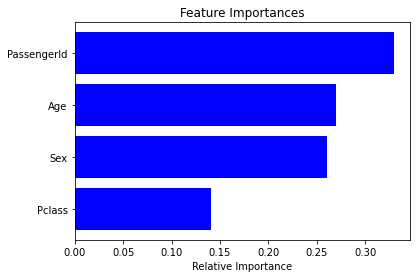

In [33]:
plotImp(importances,features)

In [34]:
#https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py
def oob_regression_r2_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) R^2 for a scikit-learn random forest
    regressor. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L702
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions

    oob_score = r2_score(y, predictions)
    return oob_score

#http://bakfu.github.io/doc/_modules/sklearn/ensemble/forest.html
from sklearn.utils import check_random_state #, check_array, compute_sample_weight
#from sklearn.utils.fixes import bincount

def generate_sample_indices(random_state, n_samples):
    """Private function used to _parallel_build_trees function."""
    random_instance = check_random_state(random_state)
    sample_indices = random_instance.randint(0, n_samples, n_samples)

    return sample_indices

def generate_unsampled_indices(random_state, n_samples):
    """Private function used to forest._set_oob_score fuction."""
    sample_indices = generate_sample_indices(random_state, n_samples)
    sample_counts = np.bincount(sample_indices, minlength=n_samples)
    unsampled_mask = sample_counts == 0
    indices_range = np.arange(n_samples)
    unsampled_indices = indices_range[unsampled_mask]

    return unsampled_indices

In [35]:
n_samples, p = X_train.shape

if (rerun):
    explainer = shap.TreeExplainer(rf)
    shapGlobal = explainer.shap_values(X_train)

    k=0
    shap_oob = np.zeros((n_samples,p, rf.n_estimators))
    shap_inbag = np.zeros((n_samples,p, rf.n_estimators))
    for tree in rf.estimators_:
      tree_preds = tree.predict(X_train)
      unsampled_indices = generate_unsampled_indices(tree.random_state, n_samples)
      sampled_indices = generate_sample_indices(tree.random_state, n_samples)
      explainer = shap.TreeExplainer(tree)
      shap_oob[unsampled_indices,:,k] = explainer.shap_values(X_train.iloc[unsampled_indices,:])
      shap_inbag[sampled_indices,:,k] = explainer.shap_values(X_train.iloc[sampled_indices,:])
      #print(k)
      k+=1

In [36]:
#from https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file

if (rerun):
    file = open('shap_oob.pkl','wb')

    pickle.dump(shapGlobal, file)
    pickle.dump(shap_oob, file)
    pickle.dump(shap_inbag, file)

    file.close()
else:
    file = open('shap_oob.pkl', 'rb')
    shapGlobal = pickle.load(file) 
    shap_oob = pickle.load(file)
    shap_inbag = pickle.load(file)

    file.close()
#explainer
#explainer.shap_values(X_train.iloc[unsampled_indices,:])
#explainer.shap_values(X_train.iloc[sampled_indices,:])

#explainer = shap.TreeExplainer(rf.estimators_[1])

In [41]:
shap_oob.shape

(571, 4, 100)

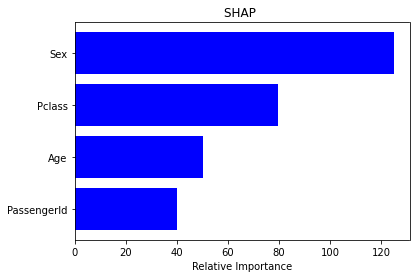

In [37]:
plotImp(np.sum(np.abs(shapGlobal), axis=0),features, main = 'SHAP ',xlab='Relative Importance')

In [38]:
shap_oob_avg = np.sum(shap_oob, axis=2) 
shap_inbag_avg = np.sum(shap_inbag, axis=2)
shap_oob_avg
globalSHAPImp_oob =np.sum(np.abs(shap_oob_avg), axis=0)
globalSHAPImp_inbag = np.sum(np.abs(shap_inbag_avg), axis=0)

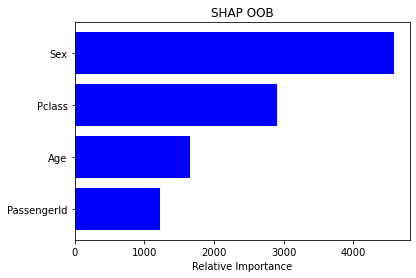

In [39]:
plotImp(globalSHAPImp_oob,features, main = 'SHAP OOB',xlab='Relative Importance')

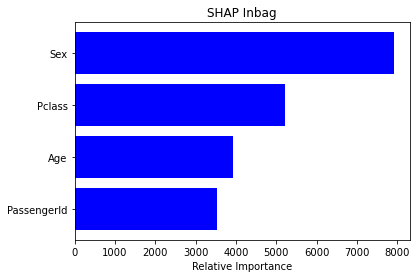

In [40]:
plotImp(globalSHAPImp_inbag,features, main = 'SHAP Inbag',xlab='Relative Importance')

In [52]:
shap_oob_avg 

array([[ 1.24633264,  3.53129469, 14.89407259,  0.21446471],
       [-2.84267112, -1.73109557, -9.0472997 , -0.41571119],
       [-0.93057564, -1.55181178, -6.91580423, -1.11319189],
       ...,
       [-3.92913967,  5.9180123 , -8.07759612, -2.04262503],
       [-0.75856113, -5.31897267, -4.16212188, -4.27873311],
       [-2.52652039,  8.93649831, 13.91815905, -2.44722628]])

In [45]:
shap_oob_avg[:,3]

array([ 2.14464705e-01, -4.15711188e-01, -1.11319189e+00, -2.27020853e+00,
       -1.08100413e+00,  5.82356832e+00, -1.57939831e+00,  4.20968642e+00,
        3.33867606e+00,  2.73941594e+00,  1.00827174e+00,  3.11588924e+00,
       -2.18584049e+00, -7.79219716e-01, -3.19390992e+00, -1.91496248e+00,
        1.08953959e+00, -3.11544002e-01, -1.71661819e+00,  2.70934251e+00,
        2.38211006e+00, -2.35200924e+00, -7.53071772e-01,  4.47974121e+00,
       -1.41297672e+00,  1.68233078e-01,  2.46718752e+00,  1.40135163e+00,
        1.23132464e+00,  1.12138846e+00,  7.60503076e+00, -1.83055101e+00,
       -1.95557714e+00,  7.19360326e-01, -4.57169311e-01, -4.85415183e+00,
        9.96721601e-01, -1.22586467e+00, -1.29486456e+00, -3.42800567e+00,
       -1.31990501e+00, -1.44870818e-01,  6.28691919e-01,  1.39158441e+00,
       -5.90653342e-02,  1.53962548e+00, -6.53229281e-02, -1.98507890e+00,
       -3.27389098e+00,  1.50452393e+00,  2.87885912e+00,  1.33341763e+00,
       -2.03697871e+00,  

In [50]:
np.savetxt("shap_oob_avg.csv", shap_oob_avg, delimiter=",")
np.savetxt("shap_inbag_avg.csv", shap_inbag_avg, delimiter=",")


In [47]:
type(Y_train)

pandas.core.series.Series

In [51]:
np.savetxt("Y_train.csv", Y_train, delimiter=",") 